In [147]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


data process for 2022 Nov APS beamline data 

7 peaks are used to calculate TC: 002, 100, 102, 103, 110, 112, 201 

plot 4 peak TC: 002,100,102,103

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
import Zn_peak_integration_lmfit_1degree_bg_7peaksTCcal_APS_2022Nov as XRD_lmfit 
import time
import re
from datetime import datetime
import datetime
from tqdm import tqdm

In [135]:
def import_file(file_path, file): 

     filename = file_path + '\\' + file 

     dataframe=pd.read_csv(filename)

     return dataframe


In [136]:
def fitting_7_peaks(dataframe, intervals): 
     # intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]
     # 002, 100, 102, 103-110, 112, 201 

     hint = [{'background_c0':9525 , 'background_c1':-938, 'amplitude':2018, 
               'center':5.582, 'sigma':0.013, 'fraction':0.35},
                                        
               {'background_c0':5130 , 'background_c1':-171, 'amplitude':15000, 
               'center':5.982, 'sigma':0.012, 'fraction':0.23},

               {'background_c0':6719 , 'background_c1':-505, 'amplitude':5692, 
               'center':8.186, 'sigma':0.012, 'fraction':0.27},

               {'background_c0':3544 , 'background_c1':-127, 'amplitude1':3438,'center1':10.301,'sigma1':0.015,
               'fraction1':0.65, 'amplitude2':7841, 'center2':10.372, 'sigma2':0.01,  'fraction2':0.36},

               {'background_c0':3908 , 'background_c1':-158, 'amplitude':8464,
               'center':11.788,'sigma':0.015,'fraction':0.28},
               
               {'background_c0':4250 , 'background_c1':-190, 'amplitude':6280, 
               'center':12.306, 'sigma':0.015, 'fraction':0.285},
               
               ]
     df_params_all,df_best_fits_all, df_differences_all, df_integrals_all = XRD_lmfit.peak_intensities_lmfit(dataframe, intervals, hint)

     return df_params_all,df_best_fits_all, df_differences_all, df_integrals_all

In [137]:
# plot fiting result of each XRD pattern of in situ data 

def plot_each_fitting_XRD(dataframe, intervals,file_path,df_best_fits,df_differences): 
    timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

    for i in tqdm(range(1,dataframe.shape[1])): 
        j=dataframe.shape[1]-i
        fig=plt.figure(figsize=(15,10))
        ax=fig.add_subplot(111)
        title=list(dataframe.columns.values)[i].split('obs_')[1].split('_primary')[0]
        plt.title(title, fontsize=15)
        plt.plot(dataframe.iloc[:,0],dataframe.iloc[:,i],linewidth=3)
        plt.xlim(3.5,12.5)
        for (start, stop) in intervals: 
            x=df_best_fits.iloc[:,0]
            xx=x[(start<=x) == (x<=stop)]
            y_simulation=df_best_fits
            yy_simulation=y_simulation[(start<=x) == (x<=stop)].iloc[:,j]
            y_difference=df_differences
            yy_difference=y_difference[(start<=x) == (x<=stop)].iloc[:,j]

            
            plt.plot(xx,yy_simulation,label='simulation',linewidth=2)
            plt.plot(xx,yy_difference,label='difference',linewidth=2)

            plt.legend()

        plt.savefig(file_path + '\\lmfit_1degree_bg_7hkl_1nelder_formula2area_reverse' +'\\lmfit_1degree_bg_7hkl_' + title + timestr + '.png', dpi=300)
        # plt.savefig(file_path + '\\lmfit_1degree_bg_' + title + timestr + '.svg', dpi=300, format='SVG')
        plt.close()


In [138]:
# extract deposition time from pattern name 

def extract_depo_time(file_path_meta,start_depo): 

     #start_depo=datetime.datetime(2023,2,24,7,7,49)

     # time_change = datetime.timedelta(minutes=2,seconds=5)

     # start_depo_real= start_depo-time_change

     time_series=XRD_lmfit.extract_time_abs(file_path_meta,start_depo)
     print(time_series)

     return time_series

In [139]:
# join deoisition time and integrals, and plot time_integrals figure and save plot

def join_time_integrals_plot(time_series,df_integrals,file_path,file): 

      
     #time_integrals=pd.merge(left,right,left_index=True,right_index=True,how="left")
     
     time_integrals = pd.merge(time_series,df_integrals,how="inner", on="image_num")
     
     print(time_integrals)
     time_integrals.columns = ['image_num','Time/min', "002 peak", 
                              "100 peak", "102 peak", "103 peak", "110 peak", 
                              "112 peak", "201 peak", 
                              ]    

     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

     fig=plt.figure(figsize=(9,6))
     ax=fig.add_subplot(111)
     title='PeakArea_lmfit_' + file.split('.csv')[0] + timestr 
     plt.title(title, fontsize=10)
     # 002, 100, 102, 103-110, 112-200, 201 
     plt.scatter(time_integrals["Time/min"], time_integrals["002 peak"], label='002')
     plt.scatter(time_integrals["Time/min"], time_integrals["100 peak"], label='100')
     plt.scatter(time_integrals["Time/min"], time_integrals["102 peak"], label='102')
     plt.scatter(time_integrals["Time/min"], time_integrals["103 peak"], label='103')
     plt.scatter(time_integrals["Time/min"], time_integrals["110 peak"], label='110')
     plt.scatter(time_integrals["Time/min"], time_integrals["112 peak"], label='112')
     plt.scatter(time_integrals["Time/min"], time_integrals["201 peak"], label='201')


     plt.xlabel('Time/min',fontsize=12)
     plt.ylabel('Peak Area',fontsize=12)

     # plt.xlim(0,21)
     # plt.ylim(-10,2750)

     plt.legend()

     plt.savefig(file_path + '\\PeakArea_lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.png', dpi=300)

     return time_integrals 


In [140]:

#simulated_Zn = [1, 0.6262055, 2.83950711, 0.48685383]

def calculate_all_TC(time_integrals): 

     simulated_Zn = {"(002)": 1, "(100)": 0.623002, "(101)": 2.822881, "(102)": 0.481876, "(103)": 0.647973, 
                    "(110)": 0.424383, "(004)": 0.103752, "(112)": 0.510745, "(200)": 0.058331, "(201)": 0.318444,
                    "(104)": 0.092161, "(202)": 0.077218, "(203)": 0.145904, "(105)": 0.121085, "(114)": 0.157887,
                    "(210)": 0.032774,"(211)": 0.185132,"(204)": 0.0272}


     time_integrals_TC = XRD_lmfit.calculate_TC(time_integrals, simulated_Zn)

     return time_integrals_TC



In [141]:

def plot_time_TC(time_integrals_TC,file_path,file): 

     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")
     
     title='PeakArea_lmfit_7hkl_' + file.split('.csv')[0] + timestr 

     integrals=time_integrals_TC

     fig=plt.figure(figsize=(9,6))
     ax=fig.add_subplot(111)
     plt.xlabel('Time/min',fontsize=12)
     ax.tick_params(width=2)
     for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(2)

     plt.ylabel('Texture Coefficient',fontsize=16)
     plt.xticks(fontsize=12)
     plt.yticks(fontsize=12)
     ax.set_ylim([0,2])

     plt.plot(integrals["Time/min"],(integrals["002 peak_TC"]),'o',label='002 TC')
     plt.plot(integrals["Time/min"],(integrals["100 peak_TC"]),'o',label='100 TC')
     plt.plot(integrals["Time/min"],(integrals["102 peak_TC"]),'o',label='102 TC')
     plt.plot(integrals["Time/min"],(integrals["103 peak_TC"]),'o',label='103 TC')
     # plt.plot(integrals["Time/min"],(integrals["110 peak_TC"]),'o',label='110 TC')
     # plt.plot(integrals["Time/min"],(integrals["112 peak_TC"]),'o',label='112 TC')
     # plt.plot(integrals["Time/min"],(integrals["201 peak_TC"]),'o',label='201 TC') 

     plt.legend(ncol=2,markerscale=2,frameon=False,fontsize=16)
     fig.suptitle(title, fontsize=12)
     plt.tight_layout()

     # plt.xlim(0,21)
     plt.ylim(0,2)
     plt.legend(loc='lower right')
     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

     fig.savefig(file_path + '\\TC_lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.png', dpi=300)

In [142]:
# save fitting results 
def save_all_data(time_integrals_TC,df_best_fits,df_differences,df_params,file_path,file): 
    timestr = "_" + time.strftime("%Y%m%d-%H%M%S")
    with pd.ExcelWriter(file_path + '\\' + 'lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.xlsx') as writer:
    
        # use to_excel function and specify the sheet_name and index
        # to store the dataframe in specified sheet
        time_integrals_TC.to_excel(writer, sheet_name="time_integrals_TC", float_format='%.5f',index=False)
        df_best_fits.to_excel(writer, sheet_name="best_fits", float_format='%.5f',index=False)
        df_differences.to_excel(writer, sheet_name="differences", float_format='%.5f',index=False)
        df_params.to_excel(writer, sheet_name="params", float_format='%.5f',index=False)

In [143]:
def do_all(file_path, file, start_depo, intervals, file_path_meta):

     
    
     dataframe=import_file(file_path, file)

     df_params_all,df_best_fits_all, df_differences_all, df_integrals_all = fitting_7_peaks(dataframe, intervals)

     print('\n')
     print('start plotting/saving fitted XRD curves')

     plot_each_fitting_XRD(dataframe, intervals,file_path,df_best_fits_all,df_differences_all)

     print(df_integrals_all)

     time_series = extract_depo_time(file_path_meta,start_depo)

     print(time_series)

     time_integrals = join_time_integrals_plot(time_series,df_integrals_all,file_path,file)

     print(time_integrals)

     time_integrals_TC = calculate_all_TC(time_integrals)

     plot_time_TC(time_integrals_TC,file_path,file) 

     save_all_data(time_integrals_TC,df_best_fits_all,df_differences_all,df_params_all,file_path,file)

     print('\n')
     print('Done! All results saved! ^^')

In [ ]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P1.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P1'

do_all(file_path, file, start_depo, intervals, file_path_meta)





In [ ]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P2.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P2'

do_all(file_path, file, start_depo, intervals, file_path_meta)

In [ ]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P3.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P3'

do_all(file_path, file, start_depo, intervals, file_path_meta)


In [ ]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P4.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P4'

do_all(file_path, file, start_depo, intervals, file_path_meta)

In [ ]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P5.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P5'

do_all(file_path, file, start_depo, intervals, file_path_meta)

In [ ]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P6.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P6'

do_all(file_path, file, start_depo, intervals, file_path_meta)

start extracting image_num:


100%|██████████| 9/9 [00:00<?, ?it/s]


['x', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008']


start fitting XRD curves:


100%|██████████| 8/8 [00:02<00:00,  3.83it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


fitted interval:  [8.0, 8.35]


100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


fitted interval:  [10.05, 10.6]


100%|██████████| 8/8 [00:01<00:00,  4.19it/s]


fitted interval:  [11.6, 11.905]


100%|██████████| 8/8 [00:01<00:00,  4.20it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 8/8 [00:17<00:00,  2.19s/it]


   image_num  [5.46, 5.71]    [5.8, 6.2]   [8.0, 8.35]  [10.05, 10.6]_1  \
0          1      0.887667  4.778260e-13  8.945265e-14     4.833572e-14   
1          2      7.542899  3.290950e+00  1.519077e+00     4.258953e+00   
2          3     18.913903  9.627350e+00  6.309922e+00     9.573552e+00   
3          4     26.853543  1.494762e+01  1.064267e+01     1.440237e+01   
4          5     37.949705  2.218363e+01  1.482258e+01     1.923623e+01   
5          6     43.939930  2.625825e+01  1.828563e+01     2.380369e+01   
6          7     49.811288  3.301691e+01  2.274792e+01     2.828108e+01   
7          8     57.848695  3.775139e+01  2.568643e+01     3.207704e+01   

   [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0         0.000000    4.829857e-12    2.697380e-12  
1         3.326561    3.831305e+00    1.654397e+00  
2         7.796771    8.006895e+00    4.999308e+00  
3        12.040760    1.380031e+01    8.703808e+00  
4        16.914126    1.735425e+01    1.139445e+01  
5     

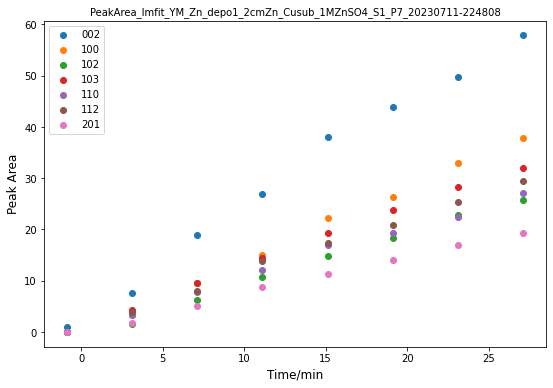

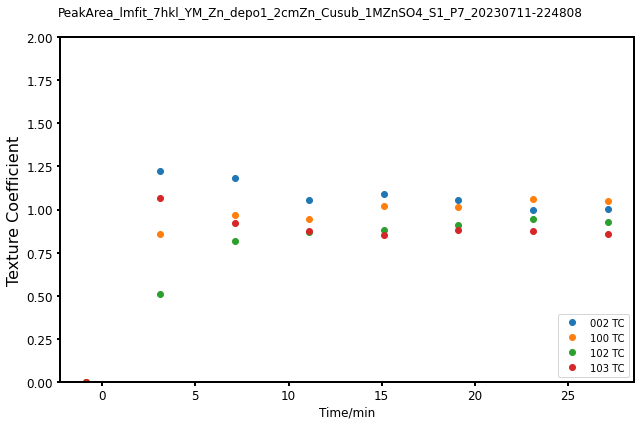

In [153]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P7.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P7'

do_all(file_path, file, start_depo, intervals, file_path_meta)

start extracting image_num:


100%|██████████| 9/9 [00:00<00:00, 9032.96it/s]


['x', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008']


start fitting XRD curves:


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


fitted interval:  [8.0, 8.35]


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


fitted interval:  [10.05, 10.6]


100%|██████████| 8/8 [00:02<00:00,  3.36it/s]


fitted interval:  [11.6, 11.905]


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


   image_num  [5.46, 5.71]    [5.8, 6.2]   [8.0, 8.35]  [10.05, 10.6]_1  \
0          1      0.577078  2.041410e-12  1.553126e-13     1.469458e-14   
1          2      4.146771  1.483456e+00  5.841648e-01     1.722818e+00   
2          3     17.183406  9.071206e+00  6.728276e+00     9.642637e+00   
3          4     34.816931  2.268983e+01  1.473409e+01     1.799341e+01   
4          5     55.764374  3.547012e+01  2.377700e+01     2.734917e+01   
5          6     69.110028  4.392660e+01  3.152941e+01     3.744126e+01   
6          7     87.666107  5.522284e+01  3.752609e+01     4.528879e+01   
7          8     96.823899  7.652955e+01  4.414821e+01     5.203549e+01   

   [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0         0.000000        0.259616    3.878950e-14  
1         1.420923        1.574424    6.937310e-01  
2         8.297255        8.122331    5.210989e+00  
3        15.262659       16.852543    1.093284e+01  
4        23.735419       24.401992    1.644862e+01  
5     

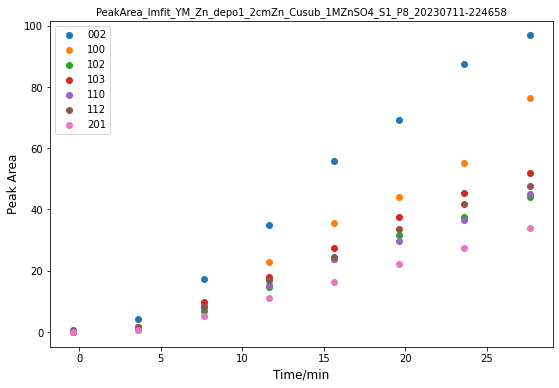

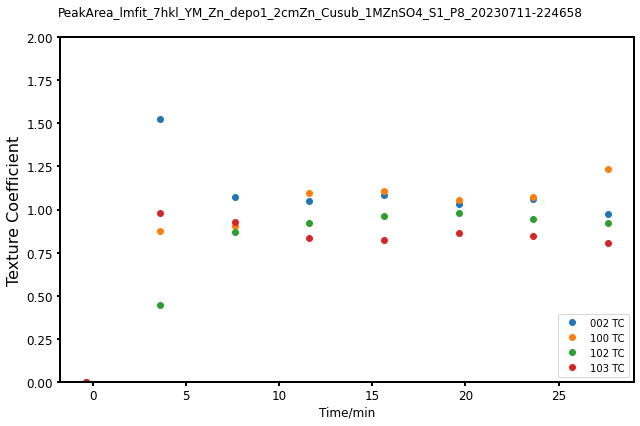

In [152]:
file_path=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1'

file=r'YM_Zn_depo1_2cmZn_Cusub_1MZnSO4_S1_P8.csv'

start_depo='11/09/2022 03:46:08 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

file_path_meta=r'D:\APS2022Nov\YM_Zn_depo\YM_Zn_depo1_2cmZn_Cusub_1MZnSO4\YM_Zn_depo1_raw_data\S1P8'

do_all(file_path, file, start_depo, intervals, file_path_meta)